# Comparing cross-validation methods

Comparing the quality and performance of the cross-validation methods implemented in [`splitters.py`](splitters.py) based on hyperparameter selection for a gradient boosting model.

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn.ensemble
import sklearn.metrics
import tqdm.notebook as tqdm

import preprocessing
import splitters

sns.set_theme(style="whitegrid")

In [2]:
X_train, y_train = preprocessing.read_tsv_with_all_features("../../data/tournament_dataset/train.tsv")
X_test, y_test = preprocessing.read_tsv_with_all_features("../../data/tournament_dataset/test.tsv")

In [3]:
splitter_params: list[tuple[str, type[splitters.Splitter], dict]] = [
    ("k-fold", splitters.KFoldSplitter, {"k": 5}),
    ("stratified k-fold", splitters.RegressionStratifiedKFoldSplitter, {"k": 5}),
    ("monte carlo", splitters.MonteCarloSplitter, {"n_splits": 5, "val_size": 0.2}),
]
results = {}
times = {}

In [4]:
def make_boosting_pipeline(**kwargs):
    return preprocessing.make_pipeline(
        sklearn.ensemble.HistGradientBoostingRegressor(
            categorical_features=preprocessing.CATEGORICAL_FEATURES, random_state=27, **kwargs
        ),
        ohe=False
    )

In [5]:
learning_rate = np.logspace(-2, 0, 7)
max_leaf_nodes = np.logspace(2, 8, 7, base=2).astype(int)

for name, cls, kwargs in splitter_params:
    results[name] = {}
    times[name] = []
    pbar = tqdm.tqdm(total=len(learning_rate) * len(max_leaf_nodes), desc=name)
    for i, lr in enumerate(learning_rate):
        for j, mln in enumerate(max_leaf_nodes):
            splitter = cls(**kwargs, random_state=i * len(max_leaf_nodes) + j)
            start = time.perf_counter()
            results[name][lr, mln] = splitter.cross_validate(
                estimator=make_boosting_pipeline(learning_rate=lr, max_leaf_nodes=mln), X=X_train, y=y_train
            )
            times[name].append(time.perf_counter() - start)
            pbar.update()

with open("results.p", "wb") as fout:
    pickle.dump({"results": results, "times": times}, fout)

k-fold:   0%|          | 0/49 [00:00<?, ?it/s]

stratified k-fold:   0%|          | 0/49 [00:00<?, ?it/s]

monte carlo:   0%|          | 0/49 [00:00<?, ?it/s]

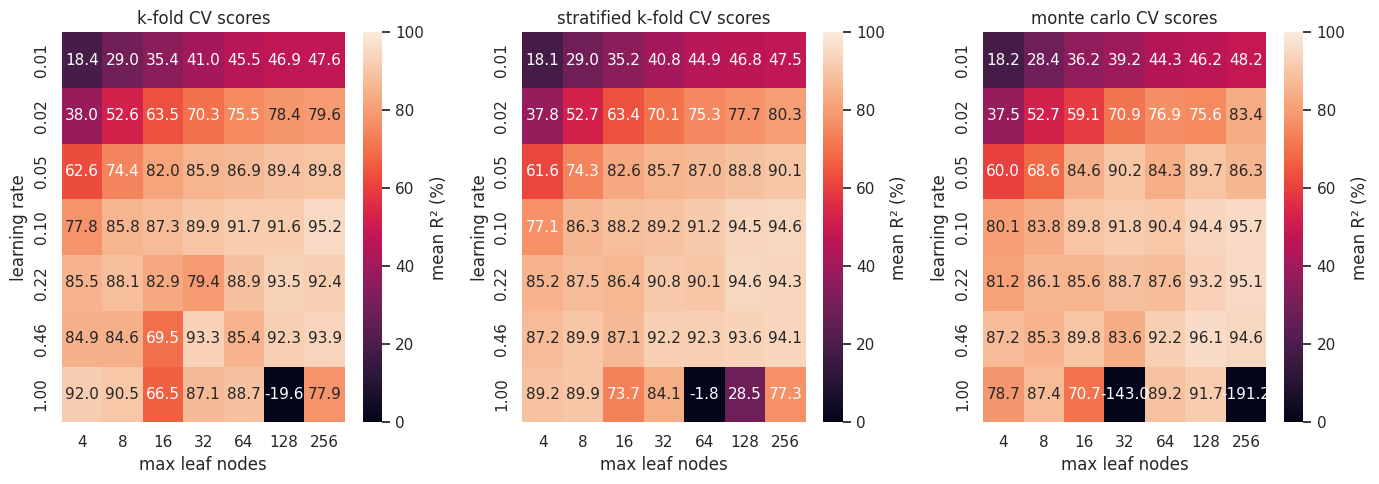

In [6]:
fig, axs = plt.subplots(ncols=3, figsize=(14, 5))

for (name, res), ax in zip(results.items(), axs):
    arr = [[res[lr, mln].mean_score for mln in max_leaf_nodes] for lr in learning_rate]
    df = pd.DataFrame(arr, index=[f"{lr:.2f}" for lr in learning_rate], columns=max_leaf_nodes)
    sns.heatmap(
        df * 100,
        annot=True, fmt=".1f", annot_kws={"fontsize": 11},
        vmin=0, vmax=100, cbar_kws={"label": "mean R² (%)"},
        ax=ax
    )
    ax.set_ylabel("learning rate")
    ax.set_xlabel("max leaf nodes")
    ax.set_title(f"{name} CV scores")

plt.tight_layout()

The vanilla k-fold method prefers a learning rate of 0.1 and a maximum leaf node count of 256, whereas the other two methods prefer a learning rate of 0.46 and a maximum leaf node count of 128. Let's see which is best on the test set (fitting the models on the entire training set this time):

In [7]:
k_fold_pref_score = make_boosting_pipeline(
    learning_rate=0.1, max_leaf_nodes=256
).fit(X_train, y_train).score(X_test, y_test)

others_pref_score = make_boosting_pipeline(
    learning_rate=0.46, max_leaf_nodes=128
).fit(X_train, y_train).score(X_test, y_test)

In [8]:
print("k-fold optimal score:")
print(k_fold_pref_score)
print()
print("stratified k-fold & monte carlo optimal score:")
print(others_pref_score)

k-fold optimal score:
0.9405000186049141

stratified k-fold & monte carlo optimal score:
0.971337095695101


The hyperparameters chosen by stratified k-fold and Monte Carlo turned out to perform better on the test set.

For a deeper comparison of which method ends up being more indicative of the model's final predictive power, let's compute the correlation between the cross-validation scores and the same models' eventual test set scores.

In [9]:
test_scores = {}

for lr, mln in tqdm.tqdm(results["k-fold"]):    # the method name doesn't matter here
    test_scores[lr, mln] = make_boosting_pipeline(
        learning_rate=lr, max_leaf_nodes=mln
    ).fit(X_train, y_train).score(X_test, y_test)

  0%|          | 0/49 [00:00<?, ?it/s]

I've decided to exclude models with `learning_rate=1` from the correlation calculation because their scores are often extremely low, which means it's not as important for their cross validation scores to correlate with their test set scores. They also seem more influenced by the randomness of split selection.

In [19]:
for name in results:
    coef = scipy.stats.spearmanr(
        [results[name][lr, mln].mean_score for lr, mln in results[name] if lr != 1],
        [test_scores[lr, mln] for lr, mln in test_scores if lr != 1]
    ).statistic
    print(f"{name} spearman correlation: {coef:.3f}")

k-fold spearman correlation: 0.800
stratified k-fold spearman correlation: 0.913
monte carlo spearman correlation: 0.853


Yet again, stratified k-fold and even the Monte Carlo method appear to predict the final model quality better than vanilla k-fold.

Let's look at the standard deviation of the scores on the splits produced by each method (that is, how different the scores turn out to be between each split of the data into a training and validation set).

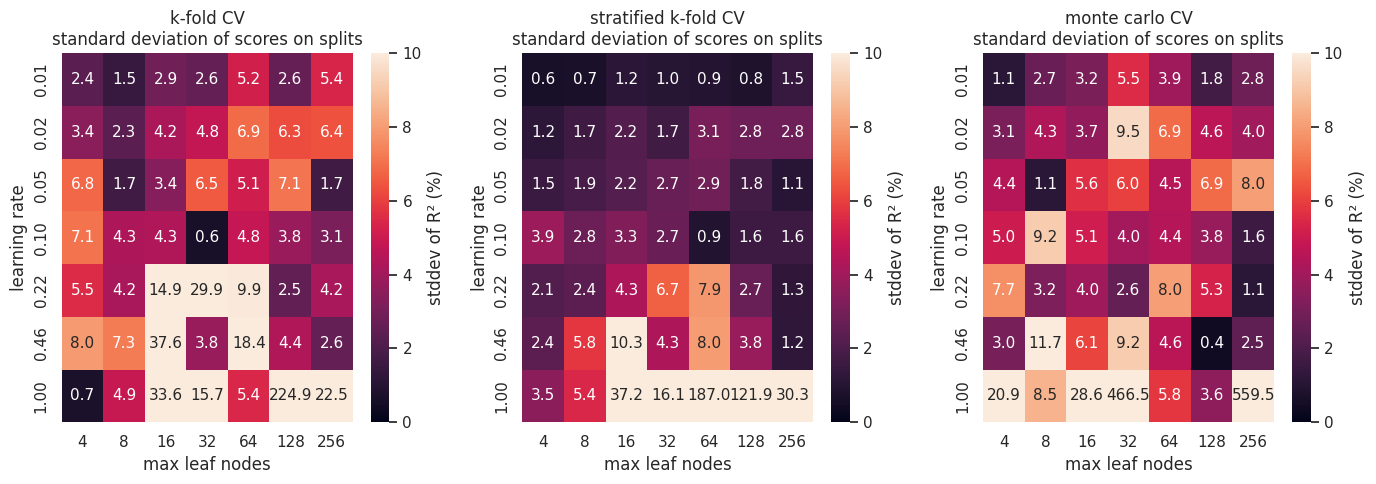

In [11]:
fig, axs = plt.subplots(ncols=3, figsize=(14, 5))

for (name, res), ax in zip(results.items(), axs):
    arr = [[np.std(res[lr, mln].split_scores) for mln in max_leaf_nodes] for lr in learning_rate]
    df = pd.DataFrame(arr, index=[f"{lr:.2f}" for lr in learning_rate], columns=max_leaf_nodes)
    sns.heatmap(
        df * 100,
        annot=True, fmt=".1f", annot_kws={"fontsize": 11},
        vmin=0, vmax=10, cbar_kws={"label": "stddev of R² (%)"},
        ax=ax
    )
    ax.set_ylabel("learning rate")
    ax.set_xlabel("max leaf nodes")
    ax.set_title(f"{name} CV\nstandard deviation of scores on splits")

plt.tight_layout()

It's clear that stratified k-fold produces the most similar splits, where the scores differ the least.


Let's compare the performance of the methods:

In [12]:
for name, times_arr in times.items():
    print(f"{name} mean time: {np.mean(times_arr):.2f} s")

k-fold mean time: 5.11 s
stratified k-fold mean time: 5.26 s
monte carlo mean time: 5.23 s


The speed of the three methods is approximately the same.

The real outlier in terms of performance is the leave-one-out method, which I didn't even include in these comparisons because of how slow it would be. On a dataset of this size it's too impractical.

To compare the leave-one-out method to the rest, let's try applying all of our CV methods on a sample size of just 1000 to test three hyperparameter combinations: a learning rate of either 0.1, 0.22 or 0.46, all with a max_leaf_size of 128. (These combinations were picked from the grid used in the previous experiments.)

For this experiment, I'm using the MSE metric instead of the R^2 score because the latter is not well-defined on just one sample.

In [13]:
rng = np.random.default_rng(seed=27)
idx = rng.choice(np.arange(len(X_train)), size=1000, replace=False)
X_sample, y_sample = X_train.iloc[idx], y_train.iloc[idx]

In [14]:
splitter_params_sample: list[tuple[str, type[splitters.Splitter], dict]] = [
    ("k-fold", splitters.KFoldSplitter, {"k": 5}),
    ("stratified k-fold", splitters.RegressionStratifiedKFoldSplitter, {"k": 5}),
    ("monte carlo", splitters.MonteCarloSplitter, {"n_splits": 5, "val_size": 0.2}),
    ("leave one out", splitters.LeaveOneOutSplitter, {})
]
results_sample = {}
times_sample = {}

In [15]:
learning_rate_sample = [0.1, 0.22, 0.46]

for name, cls, kwargs in splitter_params_sample:
    results_sample[name] = {}
    times_sample[name] = []
    pbar = tqdm.tqdm(total=len(learning_rate_sample), desc=name)
    for i, lr in enumerate(learning_rate_sample):
        if cls is splitters.LeaveOneOutSplitter:
            splitter = cls()
        else:
            splitter = cls(**kwargs, random_state=j)
        start = time.perf_counter()
        results_sample[name][lr] = splitter.cross_validate(
            estimator=make_boosting_pipeline(learning_rate=lr, max_leaf_nodes=128),
            X=X_sample, y=y_sample, scorer=sklearn.metrics.mean_squared_error
        )
        times_sample[name].append(time.perf_counter() - start)
        pbar.update()

with open("results_sample.p", "wb") as fout:
    pickle.dump({"results": results_sample, "times": times_sample}, fout)

k-fold:   0%|          | 0/3 [00:00<?, ?it/s]

stratified k-fold:   0%|          | 0/3 [00:00<?, ?it/s]

monte carlo:   0%|          | 0/3 [00:00<?, ?it/s]

leave one out:   0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
test_scores_sample = {}

for lr in tqdm.tqdm(learning_rate_sample):
    model = make_boosting_pipeline(learning_rate=lr, max_leaf_nodes=128).fit(X_sample, y_sample)
    test_scores_sample[lr] = sklearn.metrics.mean_squared_error(y_test, model.predict(X_test))

  0%|          | 0/3 [00:00<?, ?it/s]

In [17]:
dct = {
    f"{name} CV": {lr: results_sample[name][lr].mean_score for lr in results_sample[name]}
    for name in results_sample
}
dct["test set"] = test_scores_sample

pd.set_option("display.precision", 1)
pd.DataFrame(dct).T.rename(columns=lambda lr: f"lr = {lr}")

,lr = 0.1,lr = 0.22,lr = 0.46
k-fold CV,17050.8,17120.8,17073.8
stratified k-fold CV,19970.2,19565.7,18465.6
monte carlo CV,9433.9,9373.0,11340.7
leave one out CV,14151.1,14250.2,15628.7
test set,49215.6,47566.4,47069.3


Leave-one-out prefers the learning rate of 0.1, same as the stratified k-fold method. However, it turns out to be the worst when measured on the test set. These results were likely affected by randomness, but it's clear that even leave-one-out is not a guarantee of accuracy. And performance-wise it's not a contest, as leave-one-out is orders of magnitude slower:

In [18]:
pd.set_option("display.precision", 2)
pd.DataFrame([{f"{name} CV": np.mean(times_arr) for name, times_arr in times_sample.items()}], index=["mean time (s)"]).T

,mean time (s)
k-fold CV,0.57
stratified k-fold CV,0.57
monte carlo CV,0.61
leave one out CV,133.42


In conclusion, for this problem the three main cross-validation methods implemented in this project are close to each other in terms of quality and speed. Stratified k-fold appears to correlate with the model's performance on the test set slightly better than the other two methods, at least when the entire training dataset is used. It also produces much more similar scores on its different splits than vanilla k-fold and Monte Carlo. Leave-one-out is obviously much slower and in my experiment did not perform better than the other methods. It's also essentially impossible to use for large datasets unless there is a lot of computing power available.